In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
import time
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.datasets import make_moons
from sklearn.linear_model import RidgeClassifier

#Linear classification
Implementation of the **analytical** version of linear classification with Tikhonov regularization.  
Next, using the Cleveland heart disease dataset, we perform exploratory data analysis based on 13 main features.


**Analytical implementation of a linear classifier:**


In [2]:
def linear_classification(X, Y, alpha):
    beta = np.linalg.pinv(X.T @ X + alpha * np.eye(X.shape[1])) @ X.T @ Y
    return beta

def classify_points(X, beta):
    Y_pred = X @ beta

    return (Y_pred > (1/2)).astype(int)

##Preprocessing


In [3]:
import csv
import numpy as np

def load_data(file_path):
    data = []
    with open(file_path, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            data.append(row)
    return data

data = load_data('/content/HeartCleveland.csv')
data = np.array(data)

# konwertowanie danych
data[data == "?"] = np.nan
data = data.astype(float)

Let's identify **missing values** and then remove the rows containing them.


In [4]:
nan_count = np.isnan(data).sum()

print("Number of missing values:", nan_count)

Number of missing values: 6


There are a total of 6 missing values, which is not a large number, so we can safely remove them.


In [5]:
nan_indices = np.isnan(data).any(axis=1)
data = data[~nan_indices]

**Replacing the target variable with a binary value** indicating the presence of heart disease.


In [6]:
mask_0 = (data[:, -1] == 0)
mask_rest = ~mask_0

data[mask_0, -1] = 0
data[mask_rest, -1] = 1

Converting variables to categorical types.  
For all features, we will **calculate basic statistical measures** (mean/mode, standard deviation, minimum, maximum) considering the feature type (categorical/discrete/continuous).  
According to the data description, features $[1, 2, 5, 6, 8, 10, 12]$ are categorical variables. Let's start with those:


In [7]:
categorical = [1, 2, 5, 6, 8, 10, 12, 13]

for index in categorical:
    feature_values = data[:, index]
    unique_values, counts = np.unique(feature_values[~np.isnan(feature_values)], return_counts=True)

    if len(unique_values) == 0:
        print(f"Feature {index} has no available data.  ")
        continue

    print(f"\nFeature {index}:")
    print("Mode:", unique_values[np.argmax(counts)])


Feature 1:
Mode: 1.0

Feature 2:
Mode: 4.0

Feature 5:
Mode: 0.0

Feature 6:
Mode: 0.0

Feature 8:
Mode: 0.0

Feature 10:
Mode: 1.0

Feature 12:
Mode: 3.0

Feature 13:
Mode: 0.0


Now, continuous variables


In [8]:
continuous = [0, 3, 4, 7, 9, 11]

for index in continuous:
    feature_values = data[:, index]

print(f"\nFeature {index}:")
print("Mean:", np.nanmean(feature_values))
print("Standard deviation:", np.nanstd(feature_values))
print("Minimum:", np.nanmin(feature_values))
print("Maximum:", np.nanmax(feature_values))


Feature 11:
Mean: 0.6767676767676768
Standard deviation: 0.9373824451006205
Minimum: 0.0
Maximum: 3.0


Let's remove outliers from the data using the **1.5 IQR rule**, which considers observations as outliers if they fall outside the range  
$$
[Q_1 - 1.5 \cdot IQR, \quad Q_3 + 1.5 \cdot IQR]
$$  
(where $IQR$ is the difference $Q_3 - Q_1$).


In [9]:
def detect_outliers(data, column_index):
    column_data = data[:, column_index]
    column_data = column_data[~np.isnan(column_data)]
    column_data = np.sort(column_data)
    q1, q3 = np.percentile(column_data, [25, 75])
    iqr = q3 - q1
    lower = q1 - (1.5 * iqr)
    upper = q3 + (1.5 * iqr)
    outliers_indices = np.where((column_data < lower) | (column_data > upper))[0]
    print('Outliers for feature ' + str(column_index) + ' are:')
    print(outliers_indices)

for index in continuous:
    detect_outliers(data, index)

Outliers for feature 0 are:
[]
Outliers for feature 3 are:
[288 289 290 291 292 293 294 295 296]
Outliers for feature 4 are:
[292 293 294 295 296]
Outliers for feature 7 are:
[0]
Outliers for feature 9 are:
[292 293 294 295 296]
Outliers for feature 11 are:
[277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294
 295 296]


Let's remove the outlier records

In [ ]:
rows_to_remove = [0, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296]
data = np.delete(data, rows_to_remove, axis=0)

Let's check the basic statistics for continuous values after outlier removal


In [10]:
continuous = [0, 3, 4, 7, 9, 11]

for index in continuous:
    feature_values = data[:, index]

    print(f"\nFeature {index}:")
    print("Mean:", np.nanmean(feature_values))
    print("Standard deviation:", np.nanstd(feature_values))
    print("Minimum:", np.nanmin(feature_values))
    print("Maximum:", np.nanmax(feature_values))


Feature 0:
Mean: 54.54208754208754
Standard deviation: 9.034487589926636
Minimum: 29.0
Maximum: 77.0

Feature 3:
Mean: 131.69360269360268
Standard deviation: 17.73287743823472
Minimum: 94.0
Maximum: 200.0

Feature 4:
Mean: 247.35016835016836
Standard deviation: 51.909970707892114
Minimum: 126.0
Maximum: 564.0

Feature 7:
Mean: 149.5993265993266
Standard deviation: 22.90290733792757
Minimum: 71.0
Maximum: 202.0

Feature 9:
Mean: 1.0555555555555556
Standard deviation: 1.1641579568929132
Minimum: 0.0
Maximum: 6.2

Feature 11:
Mean: 0.6767676767676768
Standard deviation: 0.9373824451006205
Minimum: 0.0
Maximum: 3.0


Feature values shown as **histograms** colored according to the target variable.

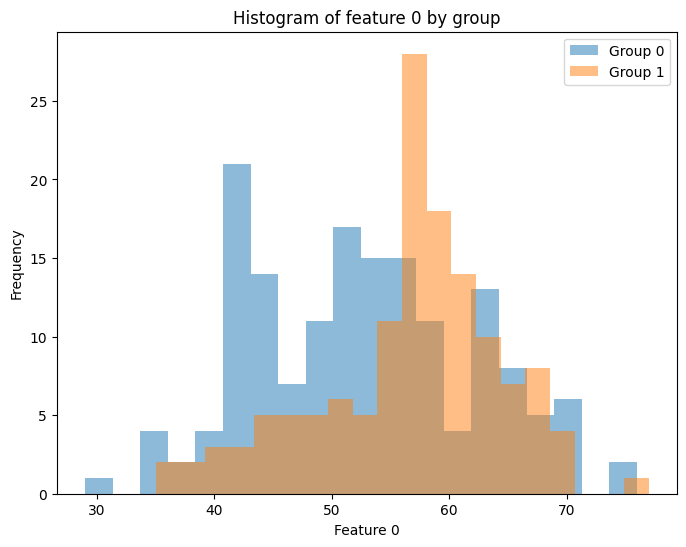

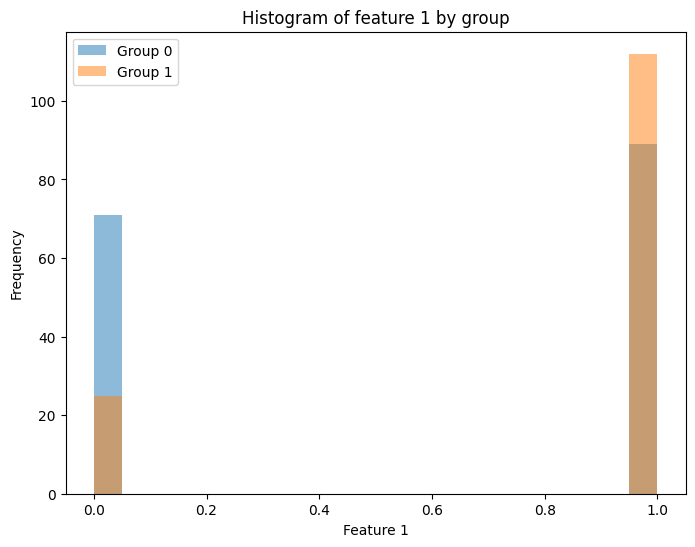

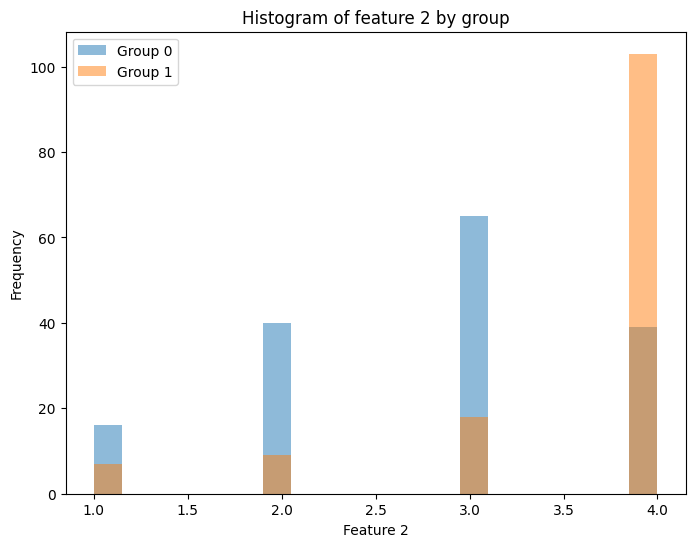

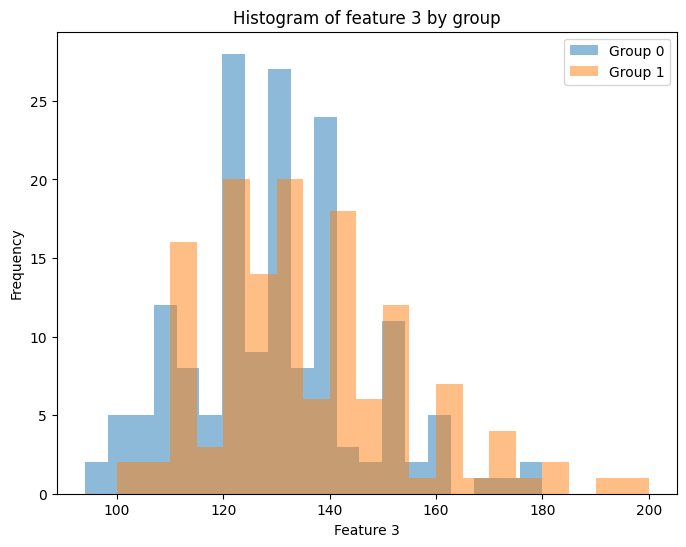

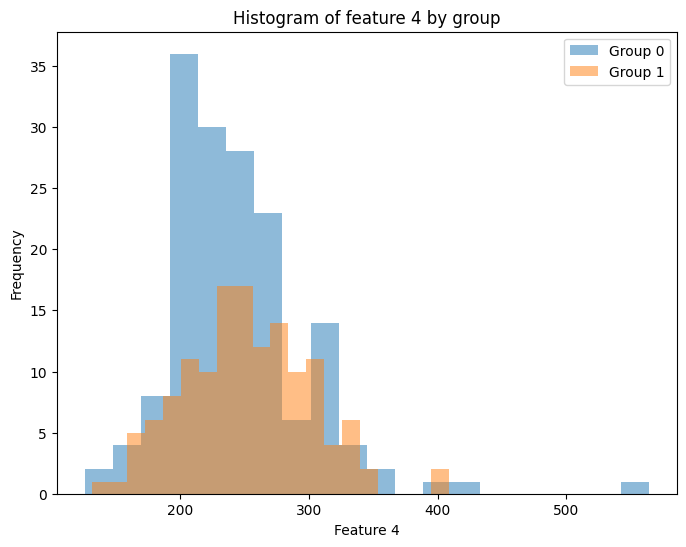

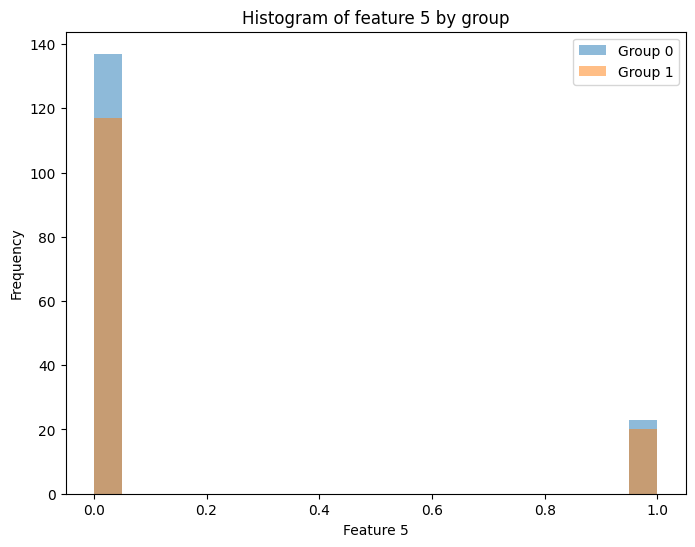

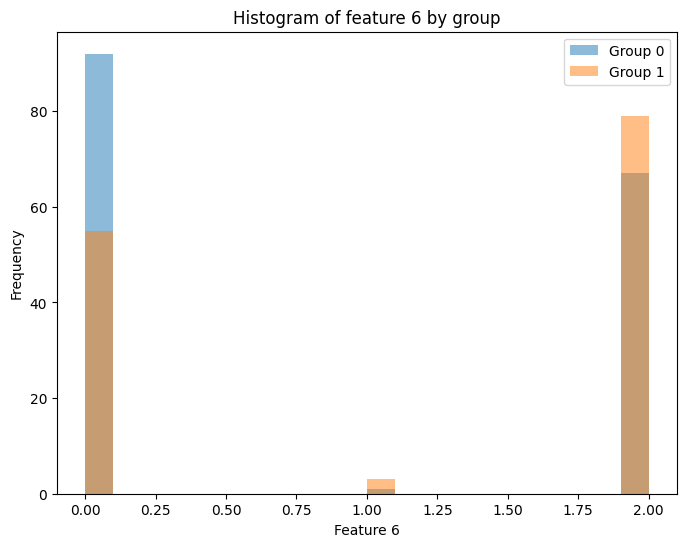

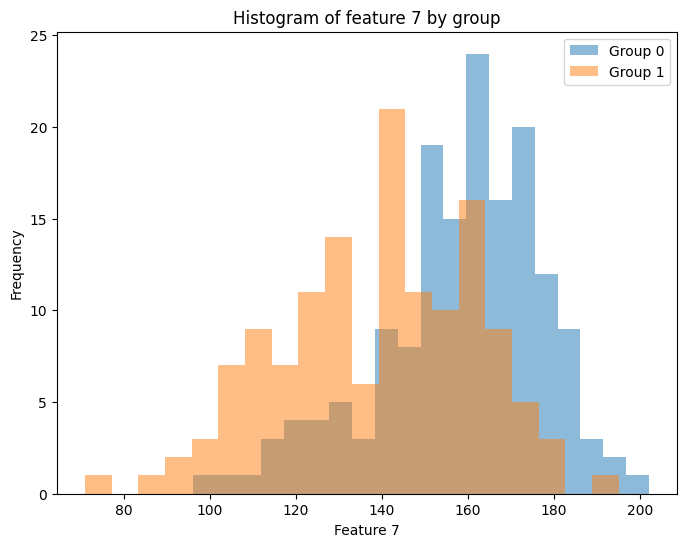

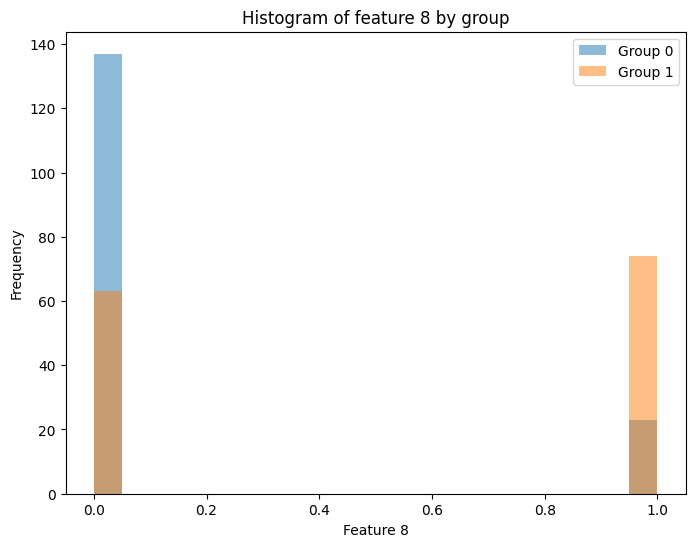

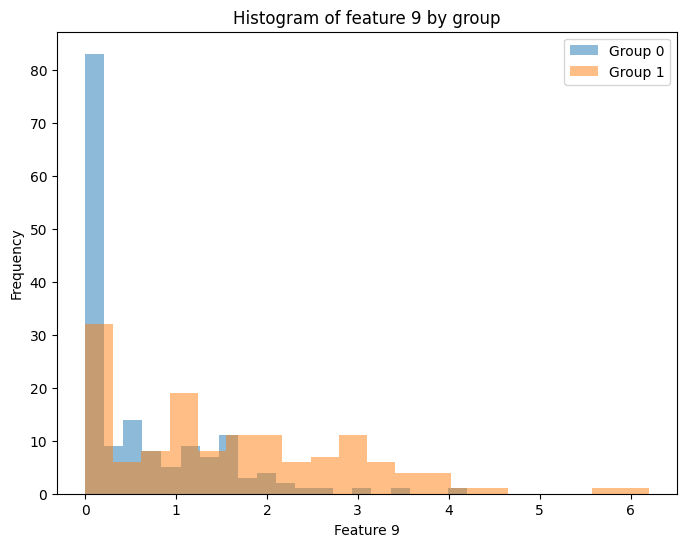

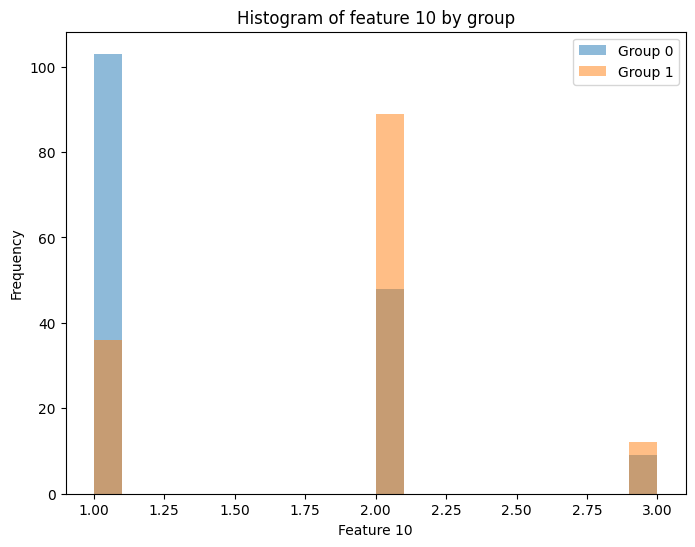

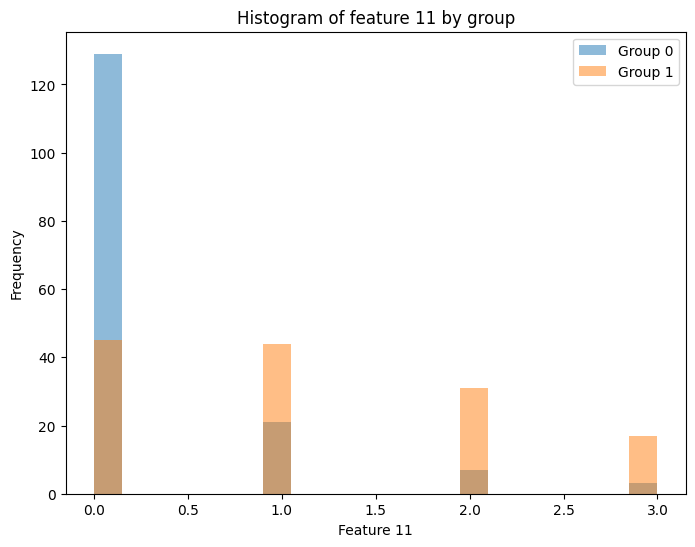

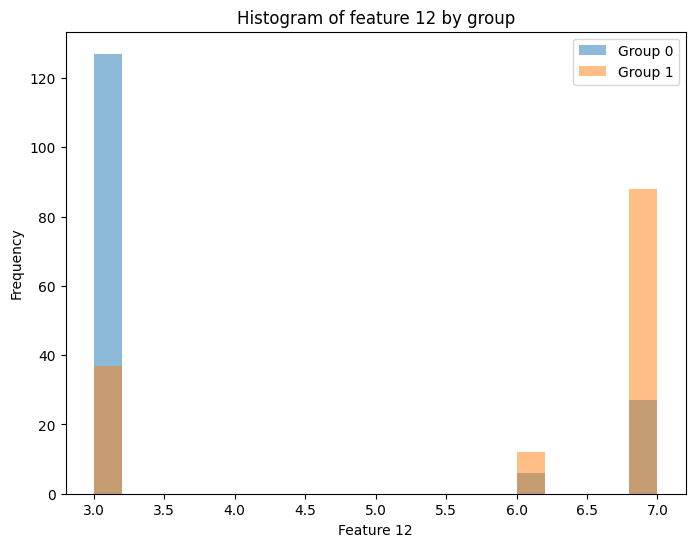

In [11]:
unique_values = np.unique(data[:, -1])

for feature_index in range(data.shape[1] - 1):
    plt.figure(figsize=(8, 6))
    for value in unique_values:
        values_for_prediction = data[data[:, -1] == value, feature_index]
        plt.hist(values_for_prediction, bins=20, alpha=0.5, label=f'Group {int(value)}')
    plt.title(f'Histogram of feature {feature_index} by group')
    plt.xlabel(f'Feature {feature_index}')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

**Correlation matrix** between features.  
Which 4 features allow for the most effective classification?


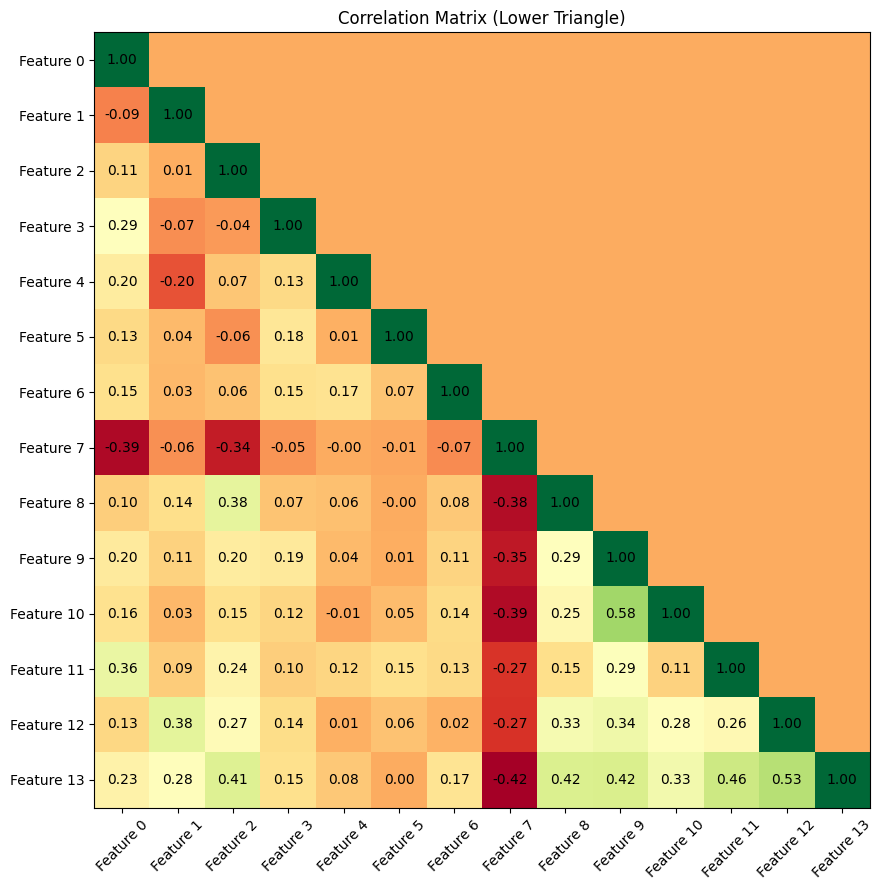

In [12]:
corr = np.corrcoef(data, rowvar=False)

plt.figure(figsize=(9, 9))

mask_lower = np.tril(np.ones_like(corr, dtype=bool))

h_map = plt.imshow(corr * mask_lower, cmap='RdYlGn', interpolation='nearest')

for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        if mask_lower[i, j]:
            plt.text(j, i, "{:.2f}".format(corr[i, j]), ha='center', va='center', color='black')

plt.title('Correlation Matrix (Lower Triangle)')
plt.xticks(np.arange(data.shape[1]), [f'Feature {i}' for i in range(data.shape[1])], rotation=45)
plt.yticks(np.arange(data.shape[1]), [f'Feature {i}' for i in range(data.shape[1])], rotation=0)
plt.tight_layout()

plt.show()

In [13]:
corelations = np.abs(corr[-1, :-1])
best = np.argsort(corelations)[-4:][::-1]
print("4 features that allow for the most effective classification:")
for i in best:
    print(f"Feature {i}")

4 features that allow for the most effective classification:
Feature 12
Feature 11
Feature 9
Feature 7


##Testing the accuracy of our implementation against RidgeClassifier
Compare the accuracy of the **custom implementation** and **RidgeClassifier** on the heart disease dataset using **13 main features**.


In [14]:
X = data[:, :-1]
Y = data[:, -1]

X = np.column_stack([np.ones(len(X)), X])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=254468)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [15]:
beta = linear_classification(X_train, y_train, alpha=0.1)
y_pred_anl = classify_points(X_test, beta)

class_0_anl = X_test[y_pred_anl == 0]
class_1_anl = X_test[y_pred_anl == 1]

In [19]:
ridge_classifier = RidgeClassifier(alpha=0.1, random_state=254468)
ridge_classifier.fit(X_train, y_train)
y_pred = ridge_classifier.predict(X_test)

class_0 = X_test[y_pred == 0]
class_1 = X_test[y_pred == 1]

In [20]:
conf_matrix_anl = confusion_matrix(y_test, y_pred_anl)

print("Confusion matrix for analytical classification:")
print(conf_matrix_anl)
print("")
conf_matrix = confusion_matrix(y_test, y_pred)

print("Confusion matrix for RidgeClassifier:")
print(conf_matrix)

Confusion matrix for analytical classification:
[[29  4]
 [ 4 23]]

Confusion matrix for RidgeClassifier:
[[29  4]
 [ 4 23]]


In [21]:
TN_anl = conf_matrix_anl[0, 0]
FP_anl = conf_matrix_anl[0, 1]
FN_anl = conf_matrix_anl[1, 0]
TP_anl = conf_matrix_anl[1, 1]

sensitivity_anl = TP_anl / (TP_anl + FN_anl)
specificity_anl = TN_anl / (TN_anl + FP_anl)

print("Sensitivity (analytical):", sensitivity_anl)
print("Specificity (analytical):", specificity_anl)
print()

TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]
TP = conf_matrix[1, 1]

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)


print("Sensitivity (RidgeClassifier):", sensitivity)
print("Specificity (RidgeClassifier):", specificity)

Sensitivity (analytical): 0.8518518518518519
Specificity (analytical): 0.8787878787878788

Sensitivity (RidgeClassifier): 0.8518518518518519
Specificity (RidgeClassifier): 0.8787878787878788


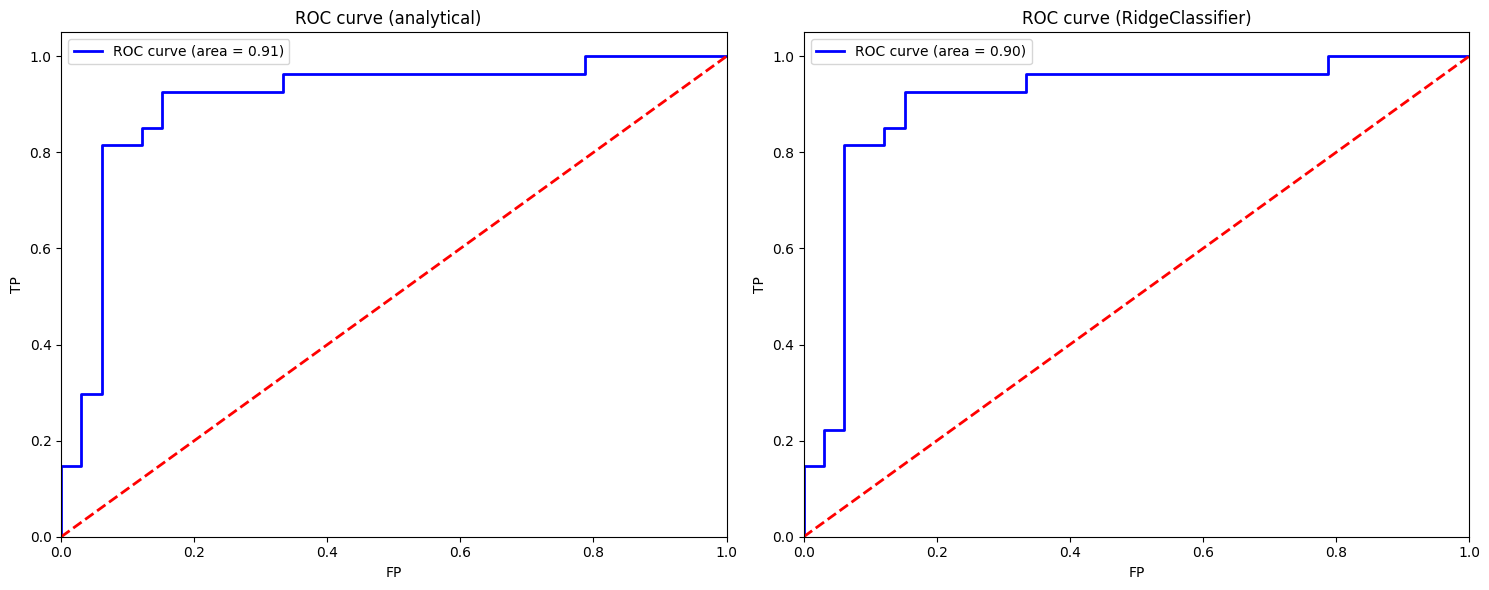

In [22]:
y_scores_anl = X_test @ beta

fpr_anl, tpr_anl, thresholds_anl = roc_curve(y_test, y_scores_anl)
roc_auc_anl = roc_auc_score(y_test, y_scores_anl)

y_scores = ridge_classifier.decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = roc_auc_score(y_test, y_scores)

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(fpr_anl, tpr_anl, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_anl)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FP')
plt.ylabel('TP')
plt.title('ROC curve (analytical)')
plt.legend(loc="lower right")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FP')
plt.ylabel('TP')
plt.title('ROC curve (RidgeClassifier)')
plt.legend(loc="lower right")
plt.legend()

plt.tight_layout()
plt.show()

As we can see, both classifiers performed the same way.


Using RidgeClassifier from sklearn and sklearn.feature_selection.SequentialFeatureSelector, let's select the 4 best features.  
We will compare **automatic feature selection** with **manual selection**.


In [23]:
X = data[:, :-1]
Y = data[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=254468)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

selector = SequentialFeatureSelector(ridge_classifier, n_features_to_select=4, direction='forward')

selector.fit(X_train_scaled, y_train)

index = selector.get_support(indices=True)
names = np.array(['Feature ' + str(i) for i in index])

print("Best features according to the selector:", names)

Best features according to the selector: ['Feature 2' 'Feature 5' 'Feature 11' 'Feature 12']


We ended up with two different sets of four features.  
Let's start with the set selected by the **selector**:


In [24]:
X = data[:, index]
Y = data[:, -1]

X = np.column_stack([np.ones(len(X)), X])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=254468)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [25]:
beta = linear_classification(X_train, y_train, alpha=0.1)
y_pred_anl = classify_points(X_test, beta)

class_0_anl = X_test[y_pred_anl == 0]
class_1_anl = X_test[y_pred_anl == 1]

In [26]:
ridge_classifier = RidgeClassifier(alpha=0.1, random_state=254468)
ridge_classifier.fit(X_train, y_train)
y_pred = ridge_classifier.predict(X_test)

class_0 = X_test[y_pred == 0]
class_1 = X_test[y_pred == 1]

In [30]:
conf_matrix_anl = confusion_matrix(y_test, y_pred_anl)

print("Confusion matrix for analytical classification:")
print(conf_matrix_anl)
print("")
conf_matrix = confusion_matrix(y_test, y_pred)

print("Confusion matrix (RidgeClassifier):")
print(conf_matrix)

Confusion matrix for analytical classification:
[[30  3]
 [ 7 20]]

Confusion matrix (RidgeClassifier):
[[30  3]
 [ 7 20]]


In [29]:
TN_anl = conf_matrix_anl[0, 0]
FP_anl = conf_matrix_anl[0, 1]
FN_anl = conf_matrix_anl[1, 0]
TP_anl = conf_matrix_anl[1, 1]

sensitivity_anl = TP_anl / (TP_anl + FN_anl)
specificity_anl = TN_anl / (TN_anl + FP_anl)

print("Sensitivity (analytical):", sensitivity_anl)
print("Specificity (analytical):", specificity_anl)
print()

TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]
TP = conf_matrix[1, 1]

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print("Sensitivity (RidgeClassifier):", sensitivity)
print("Specificity (RidgeClassifier):", specificity)


Sensitivity (analytical): 0.7407407407407407
Specificity (analytical): 0.9090909090909091

Sensitivity (RidgeClassifier): 0.7407407407407407
Specificity (RidgeClassifier): 0.9090909090909091


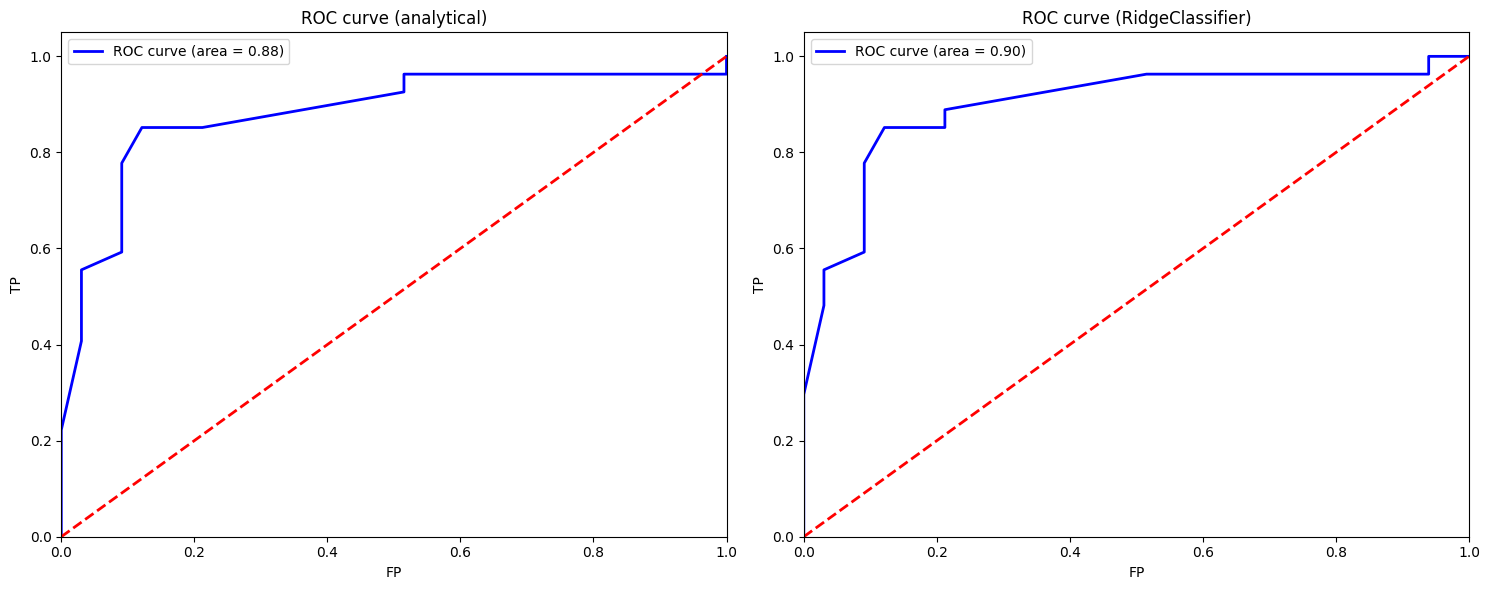

In [31]:
y_scores_anl = X_test @ beta

fpr_anl, tpr_anl, thresholds_anl = roc_curve(y_test, y_scores_anl)
roc_auc_anl = roc_auc_score(y_test, y_scores_anl)

y_scores = ridge_classifier.decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = roc_auc_score(y_test, y_scores)

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(fpr_anl, tpr_anl, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_anl)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FP')
plt.ylabel('TP')
plt.title('ROC curve (analytical)')
plt.legend(loc="lower right")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FP')
plt.ylabel('TP')
plt.title('ROC curve (RidgeClassifier)')
plt.legend(loc="lower right")
plt.legend()

plt.tight_layout()
plt.show()

Now, let's create a model using the features selected **manually**:


In [32]:
X = data[:, best]
Y = data[:, -1]

X = np.column_stack([np.ones(len(X)), X])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=254468)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [33]:
beta = linear_classification(X_train, y_train, alpha=0.1)
y_pred_anl = classify_points(X_test, beta)

class_0_anl = X_test[y_pred_anl == 0]
class_1_anl = X_test[y_pred_anl == 1]

In [34]:
ridge_classifier = RidgeClassifier(alpha=0.1, random_state=254468)
ridge_classifier.fit(X_train, y_train)
y_pred = ridge_classifier.predict(X_test)

class_0 = X_test[y_pred == 0]
class_1 = X_test[y_pred == 1]

In [35]:
conf_matrix_anl = confusion_matrix(y_test, y_pred_anl)

print("Confusion matrix for analytical classification:")
print(conf_matrix_anl)
print("")
conf_matrix = confusion_matrix(y_test, y_pred)

print("Confusion matrix (RidgeClassifier):")
print(conf_matrix)


Confusion matrix for analytical classification:
[[29  4]
 [ 6 21]]

Confusion matrix (RidgeClassifier):
[[27  6]
 [ 5 22]]


In [36]:
TN_anl = conf_matrix_anl[0, 0]
FP_anl = conf_matrix_anl[0, 1]
FN_anl = conf_matrix_anl[1, 0]
TP_anl = conf_matrix_anl[1, 1]

sensitivity_anl = TP_anl / (TP_anl + FN_anl)
specificity_anl = TN_anl / (TN_anl + FP_anl)

print("Sensitivity (analytical):", sensitivity_anl)
print("Specificity (analytical):", specificity_anl)
print()

TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]
TP = conf_matrix[1, 1]

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print("Sensitivity (RidgeClassifier):", sensitivity)
print("Specificity (RidgeClassifier):", specificity)


Sensitivity (analytical): 0.7777777777777778
Specificity (analytical): 0.8787878787878788

Sensitivity (RidgeClassifier): 0.8148148148148148
Specificity (RidgeClassifier): 0.8181818181818182


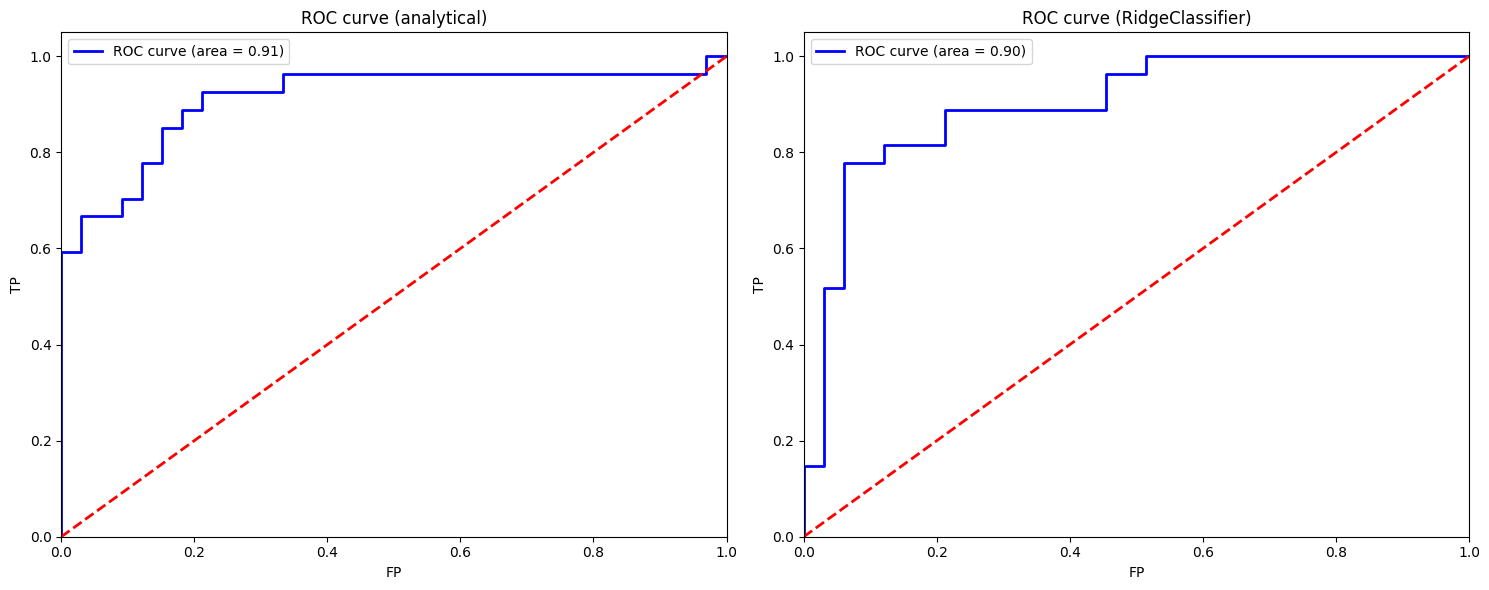

In [37]:
y_scores_anl = X_test @ beta

fpr_anl, tpr_anl, thresholds_anl = roc_curve(y_test, y_scores_anl)
roc_auc_anl = roc_auc_score(y_test, y_scores_anl)

y_scores = ridge_classifier.decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = roc_auc_score(y_test, y_scores)

plt.figure(figsize=(15, 6))

# Pierwszy wykres
plt.subplot(1, 2, 1)
plt.plot(fpr_anl, tpr_anl, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_anl)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FP')
plt.ylabel('TP')
plt.title('ROC curve (analytical)')
plt.legend(loc="lower right")
plt.legend()

# Drugi wykres
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FP')
plt.ylabel('TP')
plt.title('ROC curve (RidgeClassifier)')
plt.legend(loc="lower right")
plt.legend()

plt.tight_layout()
plt.show()

## Model Comparison:

- The confusion matrix looks slightly better (difference of one observation) for the **"manual"** feature model.
- Sensitivity is identical in both cases.
- Specificity is higher for the **"manual"** model.
- Although the ROC curves differ, the areas under the curve (AUC) are equal.

Both models perform well, with a slight advantage for the model created using **"manually"** selected features.
